In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import calendar
import datetime

In [3]:
warnings.filterwarnings("ignore")

In [161]:
df = pd.read_excel('data.xlsx')

In [162]:
df = df.drop(columns='Unnamed: 5').drop(labels = [0,1], axis = 0)

In [163]:
df.reset_index(inplace=True, drop=True)

In [164]:
df.head(10)

,client_id,sum,status,sale,new/current,document,receiving_date
0,14.0,5452.7,ОПЛАЧЕНО,Петрова,новая,оригинал,2021-07-26 00:00:00
1,15.0,13991.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00
2,16.0,719.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-06-08 00:00:00
3,18.0,4253.7,ОПЛАЧЕНО,Иванов,текущая,оригинал,2021-07-07 00:00:00
4,20.0,5796.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-07-15 00:00:00
5,21.0,3613.7,ОПЛАЧЕНО,Кузнецова,текущая,оригинал,2021-10-13 00:00:00
6,23.0,8511.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-06-08 00:00:00
7,24.0,16347.7,ОПЛАЧЕНО,Андреев,новая,оригинал,2021-06-23 00:00:00
8,28.0,10537.7,ОПЛАЧЕНО,Андреев,текущая,оригинал,2021-06-16 00:00:00
9,30.0,3833.7,ОПЛАЧЕНО,Филимонова,текущая,оригинал,2021-06-21 00:00:00


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       723 non-null    float64
 1   sum             723 non-null    float64
 2   status          728 non-null    object 
 3   sale            723 non-null    object 
 4   new/current     723 non-null    object 
 5   document        708 non-null    object 
 6   receiving_date  606 non-null    object 
dtypes: float64(2), object(5)
memory usage: 39.9+ KB


In [166]:
df["new/current"] = df["new/current"].astype("category")
df["document"] = df["document"].astype("category")

In [167]:
df['receiving_date'] = pd.to_datetime(df['receiving_date'], format='%Y/%m/%d %H:%M:%S')

In [168]:
df = df.replace('НЕТ', np.nan)

In [169]:
df = df.drop_duplicates()

In [170]:
# Вычислите общую выручку за июль 2021 по тем сделкам, приход денежных средств которых не просрочен.

In [171]:
july_2021 = df[(df['receiving_date'].dt.month == 7) & (df['receiving_date'].dt.year == 2021)] 

In [172]:
july_2021.groupby(['status']).agg({'sum': 'sum'}).drop('ПРОСРОЧЕНО')

,sum
status,
ОПЛАЧЕНО,729541.14


In [173]:
# Как изменялась выручка компании за рассматриваемый период? Проиллюстрируйте графиком.

In [174]:
monthly_revenue = df.groupby([df['receiving_date'].dt.month]).agg({'sum': 'sum'}).reset_index()

In [175]:
monthly_revenue['receiving_date'] = monthly_revenue['receiving_date'].apply(lambda x: calendar.month_abbr[int(x)])

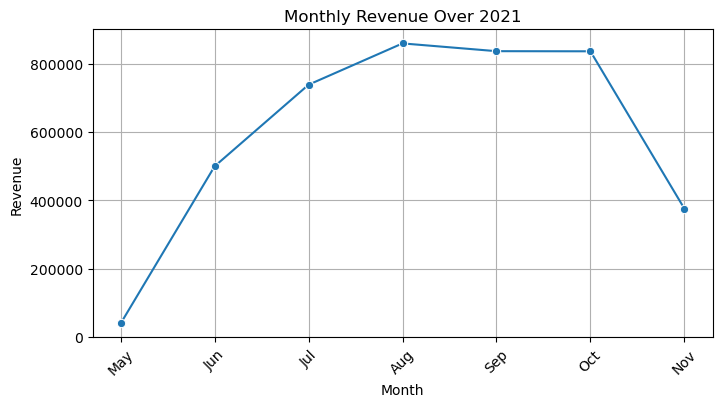

In [176]:
plt.figure(figsize=(8, 4))
sns.lineplot(x='receiving_date', y='sum', data=monthly_revenue, marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Revenue Over 2021')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [177]:
# Кто из менеджеров привлек для компании больше всего денежных средств в сентябре 2021?

In [178]:
sep_2021 = df[(df['receiving_date'].dt.month == 9) & (df['receiving_date'].dt.year == 2021)] 

In [179]:
sep_2021.groupby(['sale']).agg({'sum': 'sum'}).sort_values(by='sum', ascending=False).head(1)

,sum
sale,
Петрова,198702.32


In [180]:
# Какой тип сделок (новая/текущая) был преобладающим в октябре 2021?

In [181]:
oct_2021 = df[(df['receiving_date'].dt.month == 10) & (df['receiving_date'].dt.year == 2021)]

In [182]:
oct_2021.groupby(['new/current']).agg({'new/current': 'count'}).rename(columns={'new/current':'number of deals'})

,number of deals
new/current,
новая,17
текущая,99


In [183]:
# Сколько оригиналов договора по майским сделкам было получено в июне 2021?

In [184]:
june_2021 = df[(df['receiving_date'].dt.month == 6) & (df['receiving_date'].dt.year == 2021)]

In [185]:
oct_2021.groupby(['document']).agg({'document': 'count'}).rename(columns={'document':'number of deals'})

,number of deals
document,
оригинал,111


In [ ]:
'''
За каждую заключенную сделку менеджер получает бонус, который рассчитывается следующим образом.
1)  За новые сделки менеджер получает 7 % от суммы, при условии, что статус оплаты «ОПЛАЧЕНО», 
а также имеется оригинал подписанного договора с клиентом (в рассматриваемом месяце).
2)  За текущие сделки менеджер получает 5 % от суммы, если она больше 10 тыс., и 3 % от суммы, если меньше. 
При этом статус оплаты может быть любым, кроме «ПРОСРОЧЕНО», а также необходимо наличие 
оригинала подписанного договора с клиентом (в рассматриваемом месяце).
Бонусы по сделкам, оригиналы для которых приходят позже рассматриваемого месяца, 
считаются остатком на следующий период, который выплачивается по мере прихода оригиналов. 
Вычислите остаток каждого из менеджеров на 01.07.2021.
'''

In [204]:
def bonus_balance(df, date):
    my_date = datetime.datetime.strptime(date, "%d.%m.%Y")
    manager_bonus = {}
    
    df_filtred = df[df['receiving_date'] <= my_date]
    
    for index, row in df_filtred.iterrows():
        manager = row['sale']
        amount = row['sum']
        deal_type = row['new/current']
        
        if manager not in manager_bonus:
            manager_bonus[manager] = 0.0
        
        if row['document'] == 'оригинал':
            if row['status'] == 'ОПЛАЧЕНО' and deal_type == 'новая':
                manager_bonus[manager] += amount * 0.07
            elif row['status'] != "ПРОСРОЧЕНО" and deal_type == 'текущая':
                if amount > 10000:
                    manager_bonus[manager] += amount * 0.05
                else:
                    manager_bonus[manager] += amount * 0.03
    
    return manager_bonus

In [205]:
result = bonus_balance(df, "01.07.2021")
for manager, bonus in result.items():
    print(f"{manager}: {bonus:.2f}")

Иванов: 2716.50
Андреев: 4701.75
Филимонова: 409.68
Петрова: 7028.80
Смирнов: 4219.52
Селиванов: 353.32
Кузнецова: 2604.67
Васильев: 339.23
